In [2]:
import pandas as pd

In [3]:
df = pd.read_excel('data.xlsx')

# Убедимся, что dep_datetime — datetime
df['dep_datetime'] = pd.to_datetime(df['dep_datetime'], errors='coerce')

# Убедимся, что duration_min — числовой
df['duration_min'] = pd.to_numeric(df['duration_min'], errors='coerce')

# Удалим строки, где что-то критичное оказалось NaN
df = df.dropna(subset=['center', 'uav_type', 'dep_datetime', 'duration_min']).copy()

# Удалим аномальные длительности
df = df[(df['duration_min'] > 0) & (df['duration_min'] <= 1440)]

# Сбросим индекс
df.reset_index(drop=True, inplace=True)

print(f" Для анализа осталось {len(df)} строк.")

df.to_excel('clean_data.xlsx', index=False)

# Первые два графика:

1. Гистограмма: количество дронов за месяц (по всем регионам)

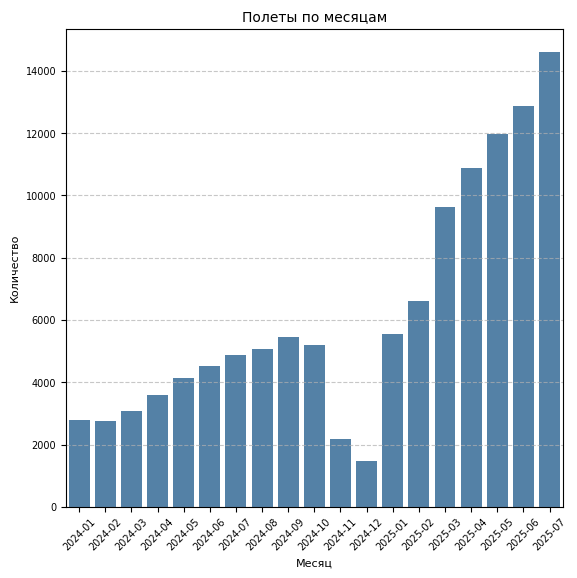

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Размер графика
plt.figure(figsize=(6, 6))

# Подготовка данных
df['month'] = df['dep_datetime'].dt.to_period('M').astype(str)
monthly_counts = df.groupby('month').size()

# Построение
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, color='steelblue')
plt.title('Полеты по месяцам', fontsize=10)
plt.xlabel('Месяц', fontsize=8)
plt.ylabel('Количество', fontsize=8)
plt.xticks(rotation=45, fontsize=7)
plt.yticks(fontsize=7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=1.5)

plt.show()

2. Гистограмма: топ-10 регионов за всё время

/tmp/ipython-input-2524015603.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=top_regions.values, y=top_regions.index, palette='viridis')


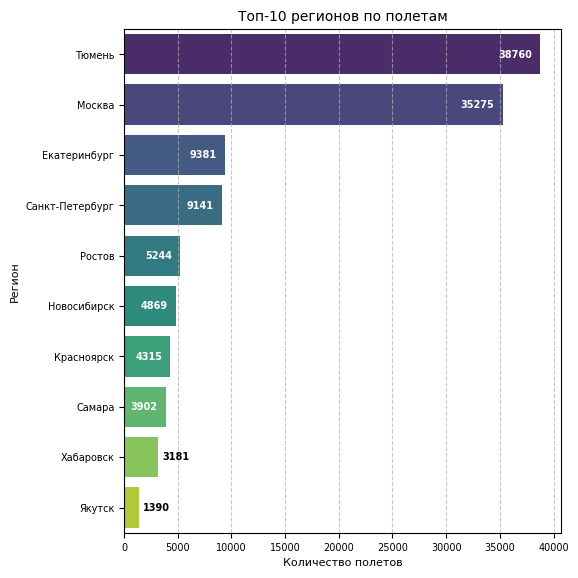

In [6]:
# plot_top10_regions_bar_local.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df = pd.read_excel('clean_data.xlsx')

plt.figure(figsize=(6, 6))

# Топ-10 регионов
top_regions = df['center'].value_counts().head(10)

# Горизонтальная гистограмма
bars = sns.barplot(x=top_regions.values, y=top_regions.index, palette='viridis')

plt.title('Топ-10 регионов по полетам', fontsize=10)
plt.xlabel('Количество полетов', fontsize=8)
plt.ylabel('Регион', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(axis='x', linestyle='--', alpha=0.7)


for i, v in enumerate(top_regions.values):
    # Размещаем текст внутри столбца, если он достаточно широкий
    if v > max(top_regions.values) * 0.1:  # если столбец >10% от максимума — пишем внутри
        color = 'white'
        x_pos = v - max(top_regions.values) * 0.02  # немного отступаем от края
    else:
        color = 'black'
        x_pos = v + max(top_regions.values) * 0.01  # пишем снаружи

    plt.text(x_pos, i, str(int(v)), color=color, fontsize=7,
             va='center', ha='right' if color == 'white' else 'left',
             fontweight='bold')

plt.tight_layout(pad=1.5)
plt.show()

# Общие графики

3. Гистограмма: количество дронов за неделю (по конкретному городу)

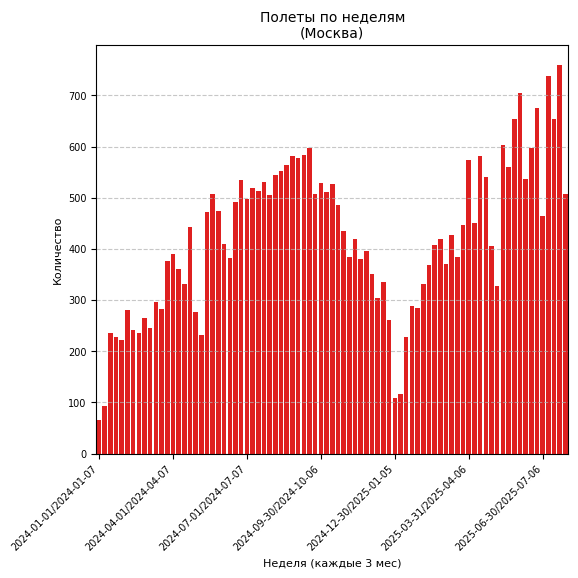

In [7]:
# plot_weekly_by_city_local.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df = pd.read_excel('clean_data.xlsx')

CITY = "Москва"  # ← Можешь изменить на нужный город

plt.figure(figsize=(6, 6))

df_city = df[df['center'] == CITY].copy()

if len(df_city) == 0:
    plt.text(0.5, 0.5, f"Нет данных\nдля {CITY}", ha='center', va='center', fontsize=12)
    plt.axis('off')
    plt.title(f'Полеты по неделям ({CITY})', fontsize=10)
else:
    # Группируем по неделям
    df_city['week'] = df_city['dep_datetime'].dt.to_period('W').astype(str)
    weekly_counts = df_city.groupby('week').size().reset_index(name='count')

    # Построение столбчатой диаграммы
    sns.barplot(data=weekly_counts, x='week', y='count', color='red')

    # Настройка оси X: показываем метку только каждые N недель
    N = 13  # каждые 13 недель ≈ каждые 3 месяца (можно 26 — полгода)
    ticks = range(0, len(weekly_counts), N)
    labels = [weekly_counts.iloc[i]['week'] if i < len(weekly_counts) else '' for i in ticks]

    plt.xticks(ticks, labels, rotation=45, fontsize=7, ha='right')
    plt.yticks(fontsize=7)

    plt.title(f'Полеты по неделям\n({CITY})', fontsize=10)
    plt.xlabel('Неделя (каждые 3 мес)', fontsize=8)
    plt.ylabel('Количество', fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(pad=1.5)

plt.show()

4. Динамика роста/падения за месяц (по конкретному городу)

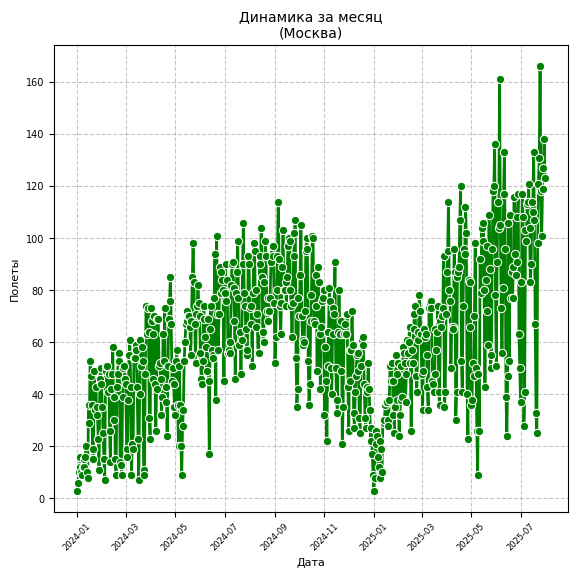

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

CITY = "Москва"  # ← Можешь изменить

plt.figure(figsize=(6, 6))

df_city = df[df['center'] == CITY].copy()

if len(df_city) == 0:
    plt.text(0.5, 0.5, f"Нет данных\nдля {CITY}", ha='center', va='center', fontsize=12)
    plt.axis('off')
    plt.title(f'Динамика за месяц ({CITY})', fontsize=10)
else:
    df_city['date'] = df_city['dep_datetime'].dt.date
    daily_counts = df_city.groupby('date').size().reset_index(name='count')

    sns.lineplot(data=daily_counts, x='date', y='count', marker='o', linewidth=2, color='green')
    plt.title(f'Динамика за месяц\n({CITY})', fontsize=10)
    plt.xlabel('Дата', fontsize=8)
    plt.ylabel('Полеты', fontsize=8)
    plt.xticks(rotation=45, fontsize=6)
    plt.yticks(fontsize=7)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout(pad=1.5)

plt.show()

5. Гистограмма: распределение по часам (утро/день/вечер разными цветами)

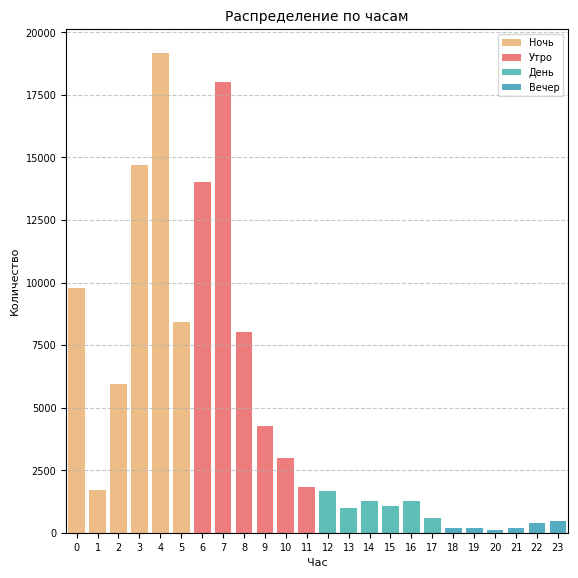

In [10]:
# plot_hourly_dayparts_local.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df = pd.read_excel('clean_data.xlsx')

plt.figure(figsize=(6, 6))

# Подготовка данных
df['hour'] = df['dep_datetime'].dt.hour

def get_daypart(hour):
    if 6 <= hour < 12: return 'Утро'
    elif 12 <= hour < 18: return 'День'
    elif 18 <= hour < 24: return 'Вечер'
    else: return 'Ночь'

df['daypart'] = df['hour'].apply(get_daypart)
hourly_counts = df.groupby(['hour', 'daypart']).size().reset_index(name='count')

palette = {
    'Утро': '#FF6B6B',   # ярко-красный
    'День': '#4ECDC4',   # бирюзовый
    'Вечер': '#45B7D1',  # насыщенный голубой
    'Ночь': '#FFBE76'    # тёплый оранжевый
}

sns.barplot(data=hourly_counts, x='hour', y='count', hue='daypart', palette=palette)

plt.title('Распределение по часам', fontsize=10)
plt.xlabel('Час', fontsize=8)
plt.ylabel('Количество', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(title='', fontsize=7, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=1.5)

plt.show()